In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_excel('Datasets/city_day.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28938 entries, 0 to 28937
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        28938 non-null  object        
 1   PM2.5       24340 non-null  float64       
 2   Date        28938 non-null  datetime64[ns]
 3   PM10        18237 non-null  float64       
 4   NO          25356 non-null  float64       
 5   NO2         25353 non-null  float64       
 6   NOx         24757 non-null  float64       
 7   NH3         19191 non-null  float64       
 8   CO          26883 non-null  float64       
 9   SO2         25089 non-null  float64       
 10  O3          24969 non-null  float64       
 11  Benzene     23321 non-null  float64       
 12  Toluene     20906 non-null  float64       
 13  Xylene      10849 non-null  float64       
 14  AQI         24257 non-null  float64       
 15  AQI_Bucket  24257 non-null  object        
dtypes: datetime64[ns](1), 

In [4]:
df['City'].value_counts()

City
Chennai               2009
Bengaluru             2009
Mumbai                2009
Lucknow               2006
Hyderabad             2004
Delhi                 2002
Patna                 1857
Gurugram              1672
Visakhapatnam         1462
Ahmedabad             1441
Amritsar              1218
Jorapokhar            1169
Jaipur                1114
Thiruvananthapuram    1112
Amaravati              951
Brajrajnagar           938
Talcher                925
Kolkata                814
Guwahati               500
Coimbatore             386
Shillong               310
Chandigarh             304
Bhopal                 289
Ernakulam              162
Kochi                  162
Aizawl                 113
Name: count, dtype: int64

In [5]:
df

,City,PM2.5,Date,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,313.22,2015-01-01,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
1,Chennai,NaN,2015-01-01,NaN,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,NaN,NaN,NaN,NaN
2,Bengaluru,NaN,2015-01-01,NaN,3.26,17.33,10.88,20.36,0.33,3.54,10.73,0.56,4.64,NaN,NaN,NaN
3,Mumbai,NaN,2015-01-01,NaN,NaN,NaN,27.38,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN
4,Lucknow,NaN,2015-01-01,NaN,2.11,13.46,4.57,NaN,12.15,169.57,25.92,1.35,3.93,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28933,Guwahati,40.00,2020-07-01,53.00,0.55,6.59,3.59,5.02,0.61,16.07,21.32,0.00,NaN,NaN,36.0,Good
28934,Shillong,16.70,2020-07-01,29.40,0.97,2.70,1.04,2.66,0.10,4.29,17.71,0.00,0.02,NaN,24.0,Good
28935,Aizawl,4.49,2020-07-01,5.39,11.44,0.07,15.11,19.41,0.02,2.07,3.39,NaN,NaN,NaN,20.0,Good
28936,Brajrajnagar,NaN,2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df[['City','Date','AQI']].copy()

In [7]:
df.isnull().sum()

City       0
Date       0
AQI     4681
dtype: int64

## Handling Missing Values

In [8]:
def season_of(m):
    if m in [2,3,4,5]:   
        return 'S1_Feb_May'
    if m in [6,7,8,9]:   
        return 'S2_Jun_Sep'
    if m in [10,11,12,1]:
        return 'S3_Oct_Jan'
        
df['Month'] = df['Date'].dt.month
df['Season'] = df['Month'].apply(season_of)

city_season_mean = df.groupby(['City','Season'])['AQI'].transform('mean')
df['AQI'] = df['AQI'].fillna(city_season_mean)

df.drop(['Month', 'Season'], axis=1, inplace=True)

In [9]:
df['AQI'] = df['AQI'].astype(int)
df.head()

,City,Date,AQI
0,Delhi,2015-01-01,472
1,Chennai,2015-01-01,120
2,Bengaluru,2015-01-01,101
3,Mumbai,2015-01-01,147
4,Lucknow,2015-01-01,325


## Outliers

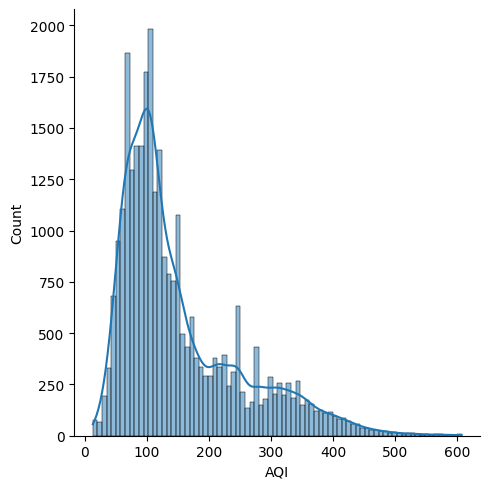

In [10]:
sns.displot(df['AQI'], kde=True)

In [11]:
Q1 = df['AQI'].quantile(0.25)
Q3 = df['AQI'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['AQI'] < lower) | (df['AQI'] > upper)]
print("Outliers:", len(outliers))


Outliers: 1208


## Forecasting

In [12]:
cities = df['City'].unique()

In [13]:
cities

array(['Delhi', 'Chennai', 'Bengaluru', 'Mumbai', 'Lucknow', 'Ahmedabad',
       'Hyderabad', 'Patna', 'Gurugram', 'Visakhapatnam', 'Amritsar',
       'Jorapokhar', 'Jaipur', 'Thiruvananthapuram', 'Amaravati',
       'Brajrajnagar', 'Talcher', 'Kolkata', 'Guwahati', 'Coimbatore',
       'Shillong', 'Chandigarh', 'Bhopal', 'Ernakulam', 'Kochi', 'Aizawl'],
      dtype=object)

In [14]:
forcasted_aqi = []

for city in cities:
    print(city)
    z = df[df['City'] == city].copy() 
    z = z[['Date','AQI']].copy()
    z = z.sort_values('Date').reset_index(drop=True)
    
    z['Month'] = z['Date'].dt.month
    z['Day'] = z['Date'].dt.day
    z['DayofWeek'] = z['Date'].dt.dayofweek
    z['Is_Weekend'] = (z['Date'].dt.weekday >= 5).astype(int)
    z['Sin_Day'] = np.sin(2 * np.pi * z['Date'].dt.dayofyear / 365)
    z['Cos_Day'] = np.cos(2 * np.pi * z['Date'].dt.dayofyear / 365)

    z['AQI_Lag1'] = z['AQI'].shift(1)
    z['AQI_Avg7'] = z['AQI'].rolling(7).mean().shift(1)

    z = z.dropna().reset_index(drop=True).copy()

    z['AQI_Lag1'] = z['AQI_Lag1'].astype(int)
    z['AQI_Avg7'] = z['AQI_Avg7'].astype(int)
    z['AQI'] = z['AQI'].astype(int)

    x = z[z['Date'] <= pd.Timestamp('2020-07-01')].copy()
    y = x['AQI'].copy()
    x = x.drop(['Date','AQI'], axis=1)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(x, y)

    dates = pd.date_range('2020-07-02', '2020-07-15')
    for d in dates:
        print(d)
        day = d.day
        month = d.month
        dayofweek = d.dayofweek
        is_weekend = 1 if dayofweek >= 5 else 0
        sin_day = np.sin(2 * np.pi * d.dayofyear / 365)
        cos_day = np.cos(2 * np.pi * d.dayofyear / 365)

        aqi_lag1 = z.loc[z['Date'] ==  pd.to_datetime(d - pd.Timedelta(days=1))]['AQI'].values[0].astype(int)

        dates = pd.date_range(d - pd.Timedelta(days=7), d - pd.Timedelta(days=1))
        aqi_avg7 = [z.loc[z['Date'] ==  pd.to_datetime(d)]['AQI'].values[0] for d in dates]
        aqi_avg7 = np.mean(aqi_avg7).astype(int)

        data = pd.DataFrame([{
            "Month": month,
            "Day": day,
            "DayofWeek": dayofweek,
            "Is_Weekend": is_weekend,
            "Sin_Day": sin_day,
            "Cos_Day": cos_day,
            "AQI_Lag1": aqi_lag1,
            "AQI_Avg7": aqi_avg7,
         }])

        pred_aqi = model.predict(data).astype(int)
        data['Date'] = d
        data['AQI'] = pred_aqi
        z = pd.concat([z, data], ignore_index=True)

        forcasted_aqi.append({'City': city, 'Date': d, 'AQI': pred_aqi})

Delhi
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
Chennai
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
Bengaluru
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
Mumbai
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-0

In [15]:
forcasted_aqi = pd.DataFrame(forcasted_aqi)
forcasted_aqi['AQI'] = forcasted_aqi['AQI'].astype(int)

In [16]:
forcasted_aqi

,City,Date,AQI
0,Delhi,2020-07-02,111
1,Delhi,2020-07-03,118
2,Delhi,2020-07-04,113
3,Delhi,2020-07-05,115
4,Delhi,2020-07-06,105
...,...,...,...
359,Aizawl,2020-07-11,19
360,Aizawl,2020-07-12,19
361,Aizawl,2020-07-13,20
362,Aizawl,2020-07-14,20


In [18]:
def get_bucket(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

forcasted_aqi['AQI_Bucket'] = forcasted_aqi['AQI'].apply(get_bucket)

In [19]:
forcasted_aqi.to_csv("forecast.csv", index=False)